In [1]:
import pandas
import os
import sys
import plotly
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
from scipy import stats
from sklearn.cross_decomposition import CCA, PLSRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error
sys.path.insert(0,'./code/')
import CrossDecomp as XD

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
%matplotlib inline

# Prepare Data

In [3]:
# Where to save figures
fig_dir = './figures/'

# If you want to save figures, just uncomment the .savefig lines in the cells below


In [4]:
# load expression data
# big file -- can take quite awhile to load!
bigdf = pandas.read_csv('data/expression.csv')

In [5]:
# change this to wherever you downloaded the Allen Brain Atlas data to
# (default is ~/abagen-data/microarry)
# allendir = '/Users/jacobv/abagen-data/microarray/'
allendir = '~/abagen-data/microarray/'
# load metadata
probes = pandas.read_csv(os.path.join(allendir,'normalized_microarray_donor10021/Probes.csv'))
gdf = pandas.read_csv('data/gxp_correlation_wholebrain_results_NEW.csv',index_col=0)

In [6]:
# harmonize indices of gene expression dataframe and meta dataframe
gdf.loc[:,'ind'] = gdf.index.values
gdf.index = gdf.well_id.values
gdf = gdf.loc[bigdf.well_id.values]
gdf.index = gdf.ind.values

In [7]:
# test
assert all(gdf.well_id.values == bigdf.well_id.values)

In [8]:
# store for subsequent notebookes
gdf.to_csv('data/meta.csv')

In [9]:
# harmonize indices cont.
bigdf.index = gdf.index
bigdf.drop('well_id',axis=1,inplace=True)

Here, we'll run PCA on the gene expression matrix to reduce dimensions before PLS

In [10]:
pcamod = PCA(n_components=100, random_state=123).fit(bigdf)
sum(pcamod.explained_variance_ratio_)

0.8460579522910678

In [11]:
# Transform gene expression data based on PCA model
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf),index = gdf.index)

In [23]:
# in case you want to save the PCA matrix, uncomment and change location
# pca_tfm.to_csv('~/Downloads/pca_matrix_Allen.csv')

At this stage, we will perform a train/test split in order to leave out some data from the PLS model for validation. We will make sure the training and testing set are consistent by stratifying by region label

In [12]:
# A few regions have too few labels for stratification. Here we group them all into one region label called "other"
too_few = [x for x in gdf.structure_acronym.value_counts().index if gdf.structure_acronym.value_counts()[x] < 2]
gdf.loc[:,'new_structure_acronym'] = ['Other' if x in too_few else x for x in gdf.structure_acronym.values]

In [13]:
# perform train test-split
gdf.loc[:,'abs_mni_nlin_x'] = abs(gdf.mni_nlin_x.values)
tr,te = train_test_split(pca_tfm, stratify=gdf.new_structure_acronym.values, random_state=123)
tr_y = gdf.loc[tr.index,['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
te_y = gdf.loc[te.index,['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]

<AxesSubplot:>

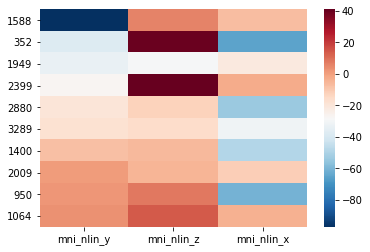

In [14]:
# create a heatmap of random xyz coordinates for a methods figure...
jnk = gdf.loc[te.index,['mni_nlin_y','mni_nlin_z','mni_nlin_x']]
sns.heatmap(jnk.loc[np.random.choice(jnk.index,10)].sort_values('mni_nlin_y'),
           cmap='RdBu_r')
# plt.savefig(os.path.join(fig_dir,'XYZ_heatmap.pdf'),
#            bbox_inches='tight')

# Train model

#### Cross-validation w/ repeated cv for CIs

Here, we run a mini grid search to detect optimal combinations of estimator (PLSR, PLSC, CCA) and n_component (1,2,3), using 10 repeats of 10-fold cross-validation.

In [15]:
from sklearn.cross_decomposition import PLSCanonical, PLSSVD
from sklearn.model_selection import KFold

ncs = 3
nc_chooser = pandas.DataFrame(index = range(ncs*3), columns = ['nc', 'estimator', 'r2','mae'])
i=0
for k,nc in enumerate(range(1,ncs+1)):
    print(nc)
    estimators = {'PLSR': PLSRegression(n_components=nc), 
                  'CCA': CCA(n_components=nc),
                 'PLSC': PLSCanonical(n_components=nc)}
    for lab, estimator in estimators.items():
        for it in range(10):
            cv=KFold(10,shuffle=True,random_state=123+it)
            pred = cross_val_predict(estimator, tr, tr_y, 
                                    groups = gdf.loc[tr.index].slab_type, 
                                     cv=cv)
            nc_chooser.loc[i, 'r2'] = r2_score(y_true=tr_y, y_pred=pred)
            nc_chooser.loc[i, 'mae'] = mean_absolute_error(y_true=tr_y, y_pred=pred)
            nc_chooser.loc[i, 'estimator'] = lab
            nc_chooser.loc[i,'nc'] = nc
            nc_chooser.loc[i,'iter'] = it
            i+=1

1
2
3


In [16]:
nc_chooser

,nc,estimator,r2,mae,iter
0,1,PLSR,0.346599,16.928226,0.0
1,1,PLSR,0.34633,16.914165,1.0
2,1,PLSR,0.346139,16.921233,2.0
3,1,PLSR,0.346413,16.903514,3.0
4,1,PLSR,0.34671,16.891774,4.0
...,...,...,...,...,...
85,3,PLSC,0.643427,12.206621,5.0
86,3,PLSC,0.64465,12.157278,6.0
87,3,PLSC,0.645913,12.142304,7.0
88,3,PLSC,0.642444,12.221011,8.0


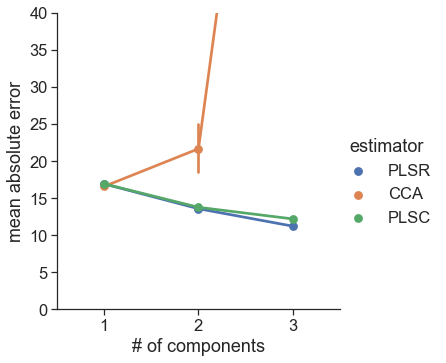

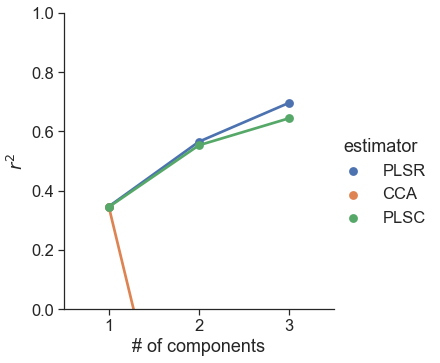

In [17]:
# plot the results

sns.set(font_scale=1.5)
sns.set_style('ticks')

sns.catplot(x = 'nc', y='mae', hue = 'estimator', 
               data=nc_chooser,aspect=1,kind='point')
plt.ylabel('mean absolute error')
plt.xlabel('# of components')
#plt.savefig(os.path.join(fig_dir,'estimator_selection_cv_mae_rkf.pdf'), bbox_inches='tight')
plt.ylim(0,40)
plt.show()

sns.catplot(x = 'nc', y='r2', hue = 'estimator', 
               data=nc_chooser,#[nc_chooser.nc<5],
               aspect=1,kind='point')
plt.ylabel('$r^{2}$')
plt.xlabel('# of components')
plt.ylim(0,1)
#plt.savefig(os.path.join(fig_dir,'estimator_selection_cv_r2_rkf.pdf'), bbox_inches='tight')
plt.show()

In [18]:
# The optimal model used PLSR with N_components = 3. Let's fit that model!
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)

PLSRegression(n_components=3)

finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400
finished iteration 500
finished iteration 600
finished iteration 700
finished iteration 800
finished iteration 900


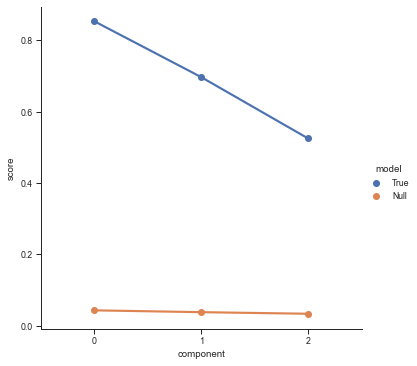

component 0: p = 0.001  ***
component 1: p = 0.001  ***
component 2: p = 0.001  ***


In [19]:
# Now we check whether the explained variance exceeds that of 1000 models with shuffled labels
results, comp_sig = XD.evaluate_components(pls_mod, tr, tr_y, n_iterations=1000)

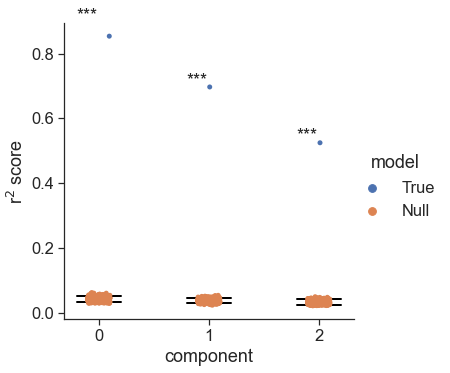

In [20]:
# Let's make that figure a bit more publication-ready
sns.set(font_scale=1.5)
sns.set_style('ticks')
sns.catplot(x='component', y='score', hue='model', data=results)
plt.text(-0.20,0.9,'***')
plt.text(0.80,0.7,'***')
plt.text(1.80,0.53,'***')
plt.ylabel('r$^2$ score')
for c in range(len(results.component.unique())):
    cvals = results[(results.model=='Null')&(results.component==c)
                ].score.sort_values().values
    cmin = cvals[25]
    cmax = cvals[975]
    plt.plot([c-.2,c+.2],[cmin,cmin],lw=2,c='black')
    plt.plot([c-.2,c+.2],[cmax,cmax],lw=2,c='black')
#plt.savefig(os.path.join(fig_dir,'sig_componentsTR.pdf'), bbox_inches='tight')

# Evaluate model

In [21]:
# fit model once again
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)

PLSRegression(n_components=3)

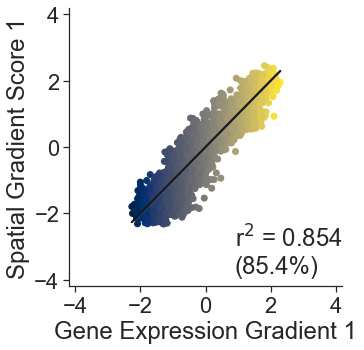

r2 = 0.8536305903100613, percent of total = 0.8536305903100613


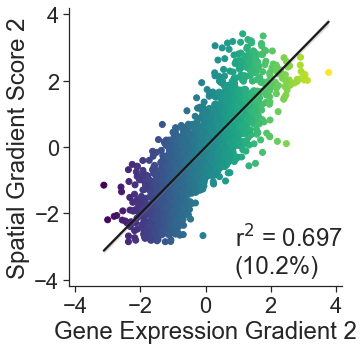

r2 = 0.6969288711885936, percent of total = 0.10200906747174979


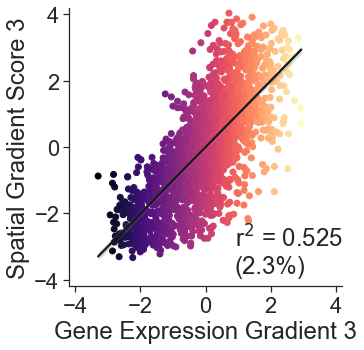

r2 = 0.5247844536368539, percent of total = 0.023279617954116143


In [22]:
# plot component scores
sns.set_context('notebook',font_scale=2)
total = 1
leftover = 1
pals = ['cividis','viridis','magma']
# for each component
for i in range(pls_mod.n_components):
    # calculate local and overall epxlained variance
    r2 = stats.pearsonr(pls_mod.x_scores_[:,i], pls_mod.y_scores_[:,i])[0]**2
    explained = (leftover * r2)
    exp_perc = explained * 100
    
    # plot correlation between latent X (gene expression) and Y (space) components
    plt.close()
    ## build plotting df
    plotr = pandas.concat([pandas.Series(pls_mod.x_scores_[:,i]),
                          pandas.Series(pls_mod.y_scores_[:,i])],
                         axis=1)
    plotr.columns = ['x','y']
    ## colors
    cmap = sns.color_palette(pals[i],as_cmap=True)
    sg = pls_mod.x_scores_[:,i]
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                   vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))
    
    ## plot
    g=sns.lmplot(x='x', y='y',data=plotr,scatter_kws={'color':cscale},line_kws={'color':'k'})
    
    ## decordations
    plt.xlim(-4.2,4.2)
    plt.ylim(-4.2,4.2)
    g.set(xticks=[-4,-2,0,2,4])
    plt.xlabel('Gene Expression Gradient %i'%(i+1))
    plt.ylabel('Spatial Gradient Score %i'%(i+1))
    plt.text(.9,-3.8,'r$^2$ = %s \n(%s%%)'%(round(r2,3),round(exp_perc,1)))
    #plt.savefig(os.path.join(fig_dir,'principal_correlation_%s.pdf'%i),bbox_inches='tight')
    plt.show()
    print('r2 = %s, percent of total = %s'%(r2, explained))
    leftover -= explained


# Test model

Now we'll apply the PLS model we fit to the left out test data to make sure the model generalizes (at least within this dataset). We'll start by predicting the spatial coordinates of different tissue samples using the 3 PLS X components and comparing those predictions to the true coordinates

In [35]:
# # grab some colors for plots
# pal=sns.color_palette('nipy_spectral',n_colors=12)
# colos = dict(zip(['Y','Z','X'],
#                 [pal[5],pal[3],pal[-1]]
#                 ))
# pal

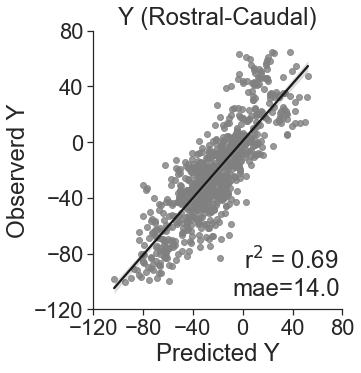

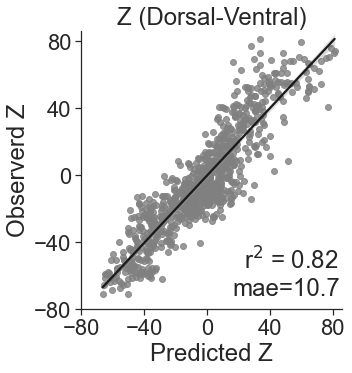

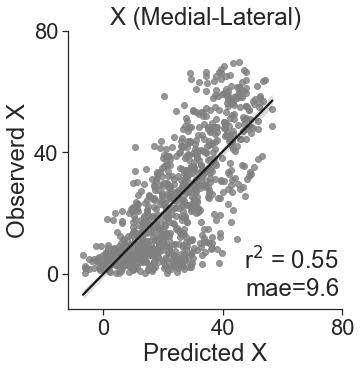

In [23]:
sns.set_context('notebook',font_scale=2)
# plot model fit

# initialize some stuff
dims = ['Y','Z','X']
labs = dict(zip(dims,['Rostral-Caudal',
                      'Dorsal-Ventral',
                      'Medial-Lateral']))

# get predicted values
te_pred = pls_mod.predict(te)

# for each component
for i in range(te_y.shape[-1]):
    # plot
    label = te_y.columns[i][-1].upper()
    plotr = pandas.concat([pandas.Series(te_pred[:,i]),
                          pandas.Series(te_y[te_y.columns[i]].values)],
                         axis=1)
    plotr.columns = ['x','y']
    g=sns.lmplot(x='x', y='y',data=plotr,
                 scatter_kws={'color':'gray', 'alpha':0.8},#colos[label]},
                 line_kws={'color':'k'}
                )
    # decorate
    pmax = np.max(plotr.max().values)
    pmin = np.min(plotr.min().values)
    incr = 40
    tmin = int(round((pmin/incr))*incr)
    tmax = int(round((pmax/incr))*incr) + 1
    trange = list(range(tmin,tmax,incr))
    plt.title('%s (%s)'%(label,labs[label]))
    plt.xlabel('Predicted %s'%label)
    plt.ylabel('Observerd %s'%label)
    plt.xlim(pmin-5,pmax+5)
    plt.ylim(pmin-5,pmax+5)
    g.set(xticks=trange,yticks=trange)
    # get stats
    r2 = stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]])[0]**2
    mae = mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]])
    plt.text(0.99,0.05,
             'r$^2$ = %s \nmae=%s'%(round(r2,2),round(mae,1)),
            transform=g.ax.transAxes,horizontalalignment='right')
    #plt.savefig(os.path.join(fig_dir,'TestRes_%s_gray.pdf'%label),bbox_inches='tight')
    plt.show()


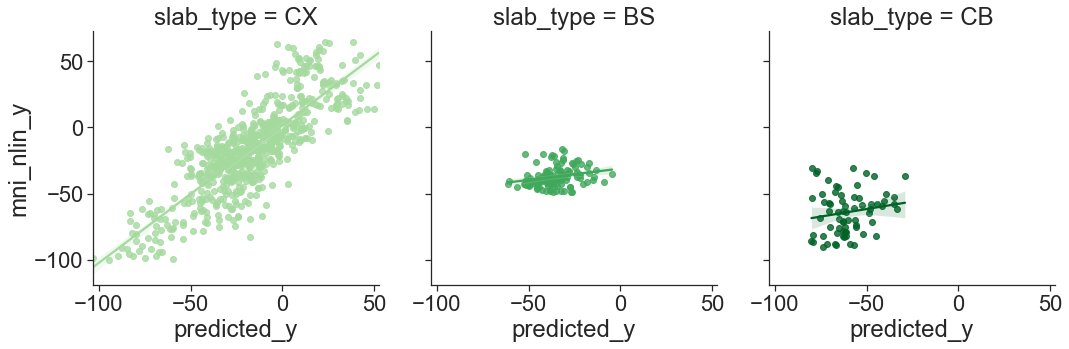

CX r2 =0.670495114117763
CX mae =14.705616290906303
BS r2 =0.06232205475443241
BS mae =9.132789166407923
CB r2 =0.02859952657360278
CB mae =15.970188816891092


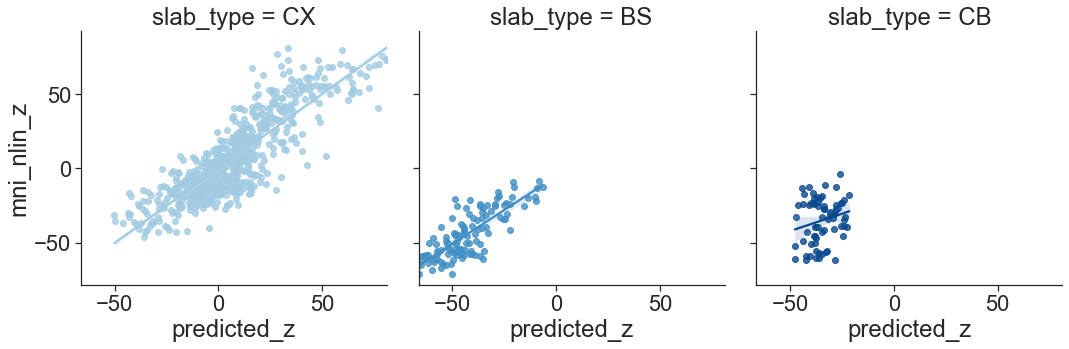

CX r2 =0.7287545017369509
CX mae =10.978404393042045
BS r2 =0.6322836599909499
BS mae =7.721480020428858
CB r2 =0.043568861075047885
CB mae =12.434931631259557


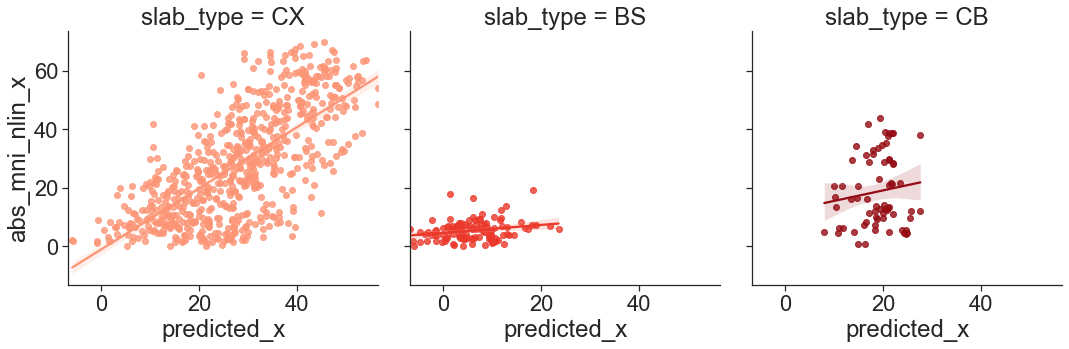

CX r2 =0.49061473183763166
CX mae =10.356870442077579
BS r2 =0.05595933251097703
BS mae =4.9085287687114825
CB r2 =0.01699789859533687
CB mae =10.629101994790528


In [24]:
# plot predictions by slab type
regpals = ['Greens','Blues','Reds']
preds_df = pandas.concat([pandas.DataFrame(te_pred, index=te_y.index), te_y],axis=1)
preds_df.columns = ['predicted_y', 'predicted_z', 'predicted_x'] + te_y.columns.tolist()
preds_df.loc[:,'slab_type'] = gdf.loc[te.index,'slab_type']
n_components = te_y.shape[-1]
for i in range(n_components):
    plt.close()
    sns.lmplot(x=preds_df.columns[i], y = preds_df.columns[i+n_components], hue = 'slab_type', 
               col = 'slab_type', data = preds_df,
              palette = list(np.array(sns.color_palette(regpals[i],10))[[3,6,9]]))
    plt.savefig(os.path.join('%s_by_slabtype.pdf'%preds_df.columns[i]),bbox_inches = 'tight')
    #plt.title(preds_df.columns[i+n_components])
    plt.show()
    for slab in preds_df.slab_type.unique():
        r2 = stats.pearsonr(preds_df[preds_df.slab_type==slab][preds_df.columns[i]],
                           preds_df[preds_df.slab_type==slab][preds_df.columns[i+n_components]]
                           )[0]**2
        mae = mean_absolute_error(preds_df[preds_df.slab_type==slab
                                          ][preds_df.columns[i]],
                                  preds_df[preds_df.slab_type==slab
                                          ][preds_df.columns[i+n_components]])
        print('%s r2 =%s'%(slab,r2))
        print('%s mae =%s'%(slab,mae))

# Build model on all data and visualize

In [25]:
# fit model to all data
pls_mod = PLSRegression(n_components=3)
full_y = gdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
pls_mod.fit(pca_tfm, full_y)

PLSRegression(n_components=3)

In [26]:
# get predicted data
pred = pls_mod.predict(pca_tfm)
preds_df = pandas.concat([pandas.DataFrame(pred, index=full_y.index), full_y],axis=1)
preds_df.columns = ['predicted_y', 'predicted_z', 'predicted_x'] + full_y.columns.tolist()
preds_df.loc[:,'slab_type'] = gdf.loc[pca_tfm.index,'slab_type']


# Visualize predictions

In [27]:
preds_df.loc[:,'structure'] = gdf.structure_acronym.values

In [28]:
# load spredsheet containing brain divisions
g2=pandas.read_csv('data/MAIN_gcx_wholebrain_info_W_BRAIN_DIVISIONS.csv',
                  index_col=0)
g2.drop(g2.columns[0],axis=1,inplace=True)
g2 = g2.loc[gdf.index]

In [29]:
# simplify labels slightly for visualization
bd2 = ['Temporal' if x == 'Limbic' else\
      'Subcortex' if x in ['Thalamus','Striatum',
                           'Hypothalamus','Forebrain',
                           'Other_Dien'] else\
      'Brainstem' if x in ['Medulla','Pons',
                           'Tegmentum','Tectum'] else\
      'Frontal' if x in ['Anterior_Cingulate','Insula'] else\
      'Parietal' if x == 'Posterior_Cingulate' else\
      'Cerebellum' if x == 'DCN' else\
      x for x in g2.brain_divison.values]
g2.loc[:,'BD2'] = bd2

Plot observed coordinates of tissue samples (Y and Z axes for saggital view)

(-115.0, 75.0)

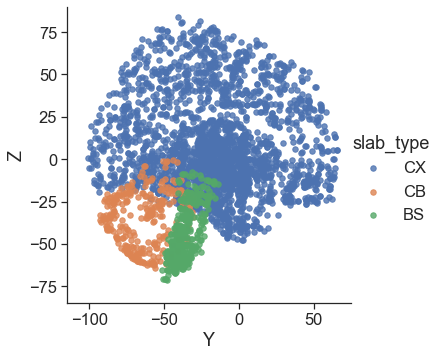

In [30]:
sns.set_context('notebook',font_scale=1.5)
sns.lmplot(x='mni_nlin_y', y='mni_nlin_z', hue = 'slab_type', data=gdf, fit_reg=False, 
           scatter_kws={"s": 30})
plt.xlabel('Y')
plt.ylabel('Z')
plt.ylim(-85,90)
plt.xlim(-115,75)

(-115.0, 75.0)

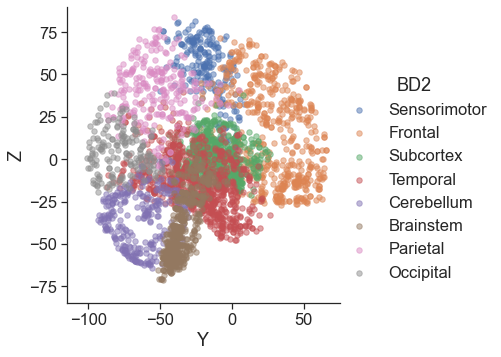

In [31]:
sns.set_context('notebook',font_scale=1.5)
sns.lmplot(x='mni_nlin_y',y='mni_nlin_z', hue = 'BD2', data=g2, 
           fit_reg=False, 
           scatter_kws={"s": 30,'alpha':0.5})
plt.xlabel('Y')
plt.ylabel('Z')
plt.ylim(-85,90)
plt.xlim(-115,75)
#plt.savefig(os.path.join(fig_dir,'brain_plot_YZ_div.png'),bbox_inches='tight')

Plot predicted coordinates from PLS model (Y and Z axes for saggital view)

(-115.0, 75.0)

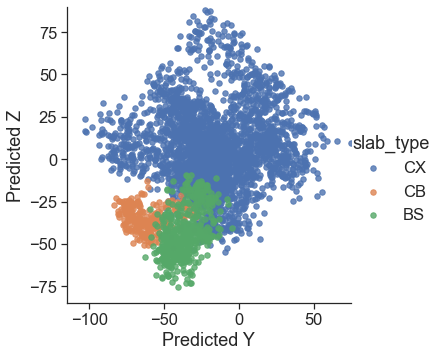

In [32]:
sns.lmplot(x='predicted_y', y='predicted_z', hue = 'slab_type', 
           data=preds_df, 
           fit_reg=False, scatter_kws={"s": 30})
plt.xlabel('Predicted Y')
plt.ylabel('Predicted Z')
plt.ylim(-85,90)
plt.xlim(-115,75)


(-115.0, 75.0)

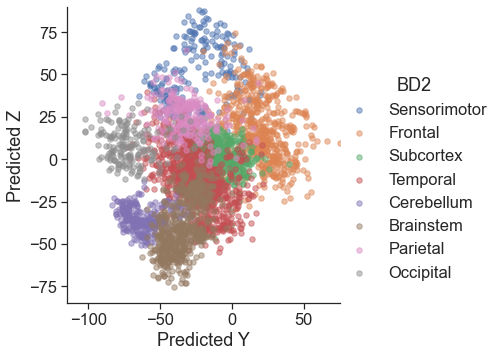

In [33]:
preds_df.loc[:,'BD2'] = bd2
sns.lmplot(x='predicted_y', y='predicted_z', hue = 'BD2', data=preds_df, 
           fit_reg=False, 
           scatter_kws={"s": 30,'alpha':0.5})
plt.xlabel('Predicted Y')
plt.ylabel('Predicted Z')
plt.ylim(-85,90)
plt.xlim(-115,75)
#plt.savefig(os.path.join(fig_dir,'brain_plot_YZ_pred_div.png'),bbox_inches='tight')

# Examine error

In [34]:
# quantify observation-level error
preds_df.loc[:,'error_y'] = abs(preds_df.predicted_y.values -\
                                preds_df.mni_nlin_y.values)
preds_df.loc[:,'error_z'] = abs(preds_df.predicted_z.values -\
                                preds_df.mni_nlin_z.values)
preds_df.loc[:,'error_x'] = abs(preds_df.predicted_x.values -\
                                preds_df.abs_mni_nlin_x.values)
preds_df.loc[:,'total_error'] = preds_df[['error_y',
                                          'error_z',
                                          'error_x']].mean(1).values
preds_df.loc[:,'mni_nlin_x'] = gdf.mni_nlin_x.values

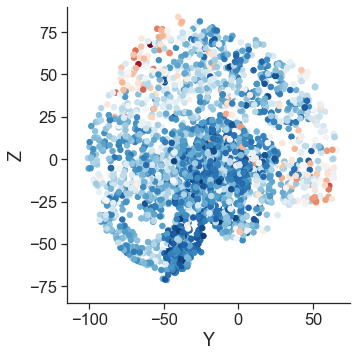

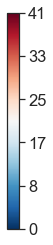

In [35]:
# plot overall error (w/ a colorbar for reference)

import matplotlib.colors

# prep colors
cmap = sns.color_palette('RdBu_r',as_cmap=True)
norm = matplotlib.colors.Normalize(vmin=preds_df.total_error.min(), 
                                   vmax=preds_df.total_error.max())
cscale = cmap(norm(preds_df.total_error.values))
# plot
g = sns.lmplot(x='mni_nlin_y', y='mni_nlin_z', 
              legend=True, 
               data=preds_df, fit_reg=False, 
               scatter_kws={"s": 30,'color':cscale},
              palette='RdBu_r')
# decorate
plt.xlabel('Y')
plt.ylabel('Z')
plt.ylim(-85,90)
plt.xlim(-115,75)
plt.xticks([-100,-50,0,50])
plt.yticks(list(range(-75,76,25)))
#plt.savefig(os.path.join(fig_dir,'brain_plot_error_YZ.png'),bbox_inches='tight')

# plot colorbar
a = np.array([[0,1]])
plt.figure(figsize=(.2, 5))
img = plt.imshow(a, cmap="RdBu_r")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(orientation="vertical", cax=cax)
newticks = [int(round(norm.inverse(x))) for x in cbar.get_ticks()]
cbar.set_ticks(cbar.get_ticks())
cbar.set_ticklabels(newticks)
#plt.savefig(os.path.join(fig_dir,'brain_plot_error_YZ_cbar.pdf'),bbox_inches='tight')




([<matplotlib.axis.YTick at 0x12ebb8f28>,
 [Text(0, -100.0, '−100'),
  Text(0, -75.0, '−75'),
  Text(0, -50.0, '−50'),
  Text(0, -25.0, '−25'),
  Text(0, 0.0, '0'),
  Text(0, 25.0, '25'),
  Text(0, 50.0, '50')])

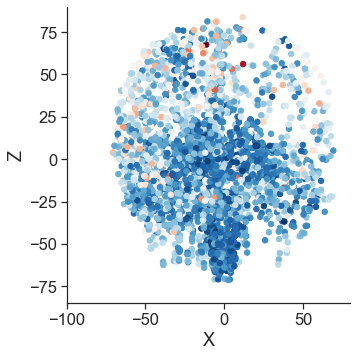

In [36]:
# same thing but from a different view
cmap = sns.color_palette('RdBu_r',as_cmap=True)
norm = matplotlib.colors.Normalize(vmin=preds_df.total_error.min(), 
                                   vmax=preds_df.total_error.max())
cscale = cmap(norm(preds_df.total_error.values))

g = sns.lmplot(x='mni_nlin_x', y='mni_nlin_z', 
              legend=True, 
               data=preds_df, fit_reg=False, 
               scatter_kws={"s": 30,'color':cscale},
              palette='RdBu_r')
plt.xlabel('X')
plt.ylabel('Z')
plt.ylim(-85,90)
plt.xlim(-80,80)
plt.xticks([-100,-50,0,50])
plt.yticks(list(range(-75,76,25)))
#plt.savefig(os.path.join(fig_dir,'brain_plot_error_XZ.pdf'),bbox_inches='tight')




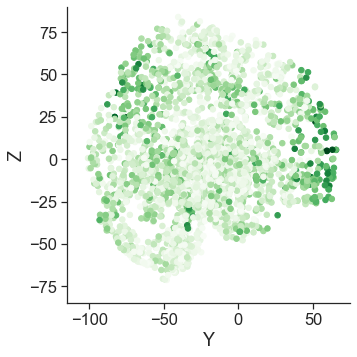

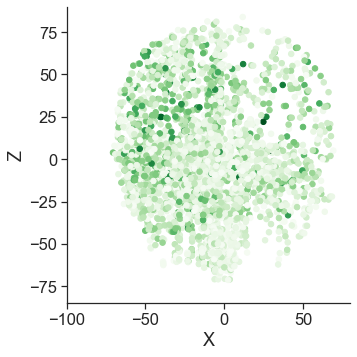

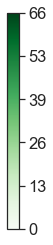

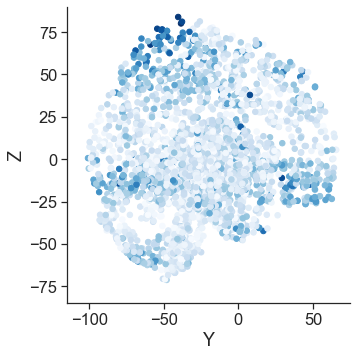

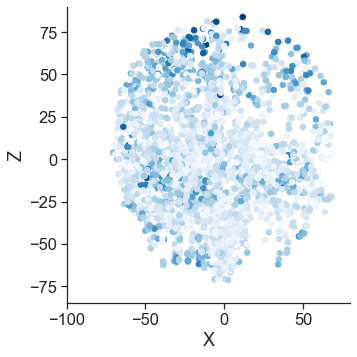

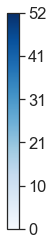

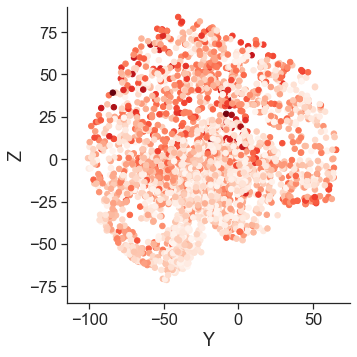

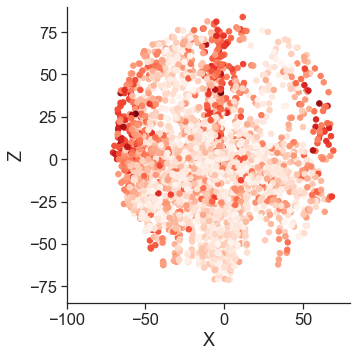

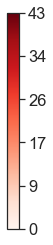

In [37]:
# next let's plot the spatial error for each dimension: x, y and z. With multiple views and colorbars

for i,col in enumerate(['error_y','error_z','error_x',]):
    cmap = sns.color_palette(regpals[i],as_cmap=True)
    c = col[-1].upper()
    norm = matplotlib.colors.Normalize(vmin=preds_df[col].min(), 
                                       vmax=preds_df[col].max())
    cscale = cmap(norm(preds_df[col].values))

    g = sns.lmplot(x='mni_nlin_y', y='mni_nlin_z', 
                  legend=True, 
                   data=preds_df, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.ylim(-85,90)
    plt.xlim(-115,75)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
    #plt.savefig(os.path.join(fig_dir,'brain_plot_%serror_YZ.pdf'%c),bbox_inches='tight')
    plt.show()

    g = sns.lmplot(x='mni_nlin_x', y='mni_nlin_z', 
                  legend=True, 
                   data=preds_df, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.ylim(-85,90)
    plt.xlim(-80,80)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
    #plt.savefig(os.path.join(fig_dir,'brain_plot_%serror_XZ.pdf'%c),bbox_inches='tight')
    plt.show()

    # colorbar
    a = np.array([[0,1]])
    plt.figure(figsize=(.2, 5))
    img = plt.imshow(a, cmap=regpals[i])
    plt.gca().set_visible(False)
    cax = plt.axes([0.1, 0.2, 0.8, 0.6])
    cbar = plt.colorbar(orientation="vertical", cax=cax)
    newticks = [int(round(norm.inverse(x))) for x in cbar.get_ticks()]
    cbar.set_ticks(cbar.get_ticks())
    cbar.set_ticklabels(newticks)
    #plt.savefig(os.path.join(fig_dir,'brain_plot_%serror_YZ_cbar.pdf'%c),bbox_inches='tight')
    
    plt.show()




In [38]:
# is extremity or distance from center related to error?

# extremity -- mean distance from all other samples
from scipy.spatial.distance import cdist
distmat = cdist(full_y.round(4).values,full_y.round(4).values)
dm = pandas.DataFrame(distmat)

preds_df.loc[:,'extremity'] = dm.mean(1).values

# distance from center
preds_df.loc[:,'abs_mni_nlin_y'] = preds_df.mni_nlin_y.abs().values
preds_df.loc[:,'abs_mni_nlin_z'] = preds_df.mni_nlin_z.abs().values
preds_df.loc[:,'center_dist'] = preds_df[['abs_mni_nlin_x','abs_mni_nlin_y',
                               'abs_mni_nlin_z']].mean(1).values

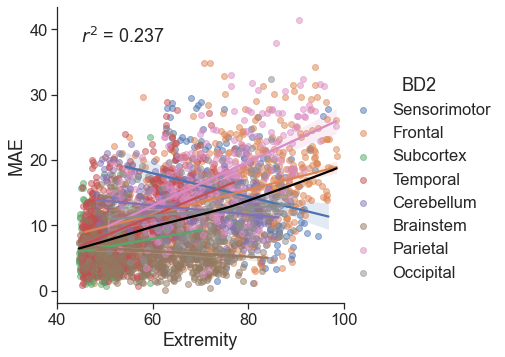

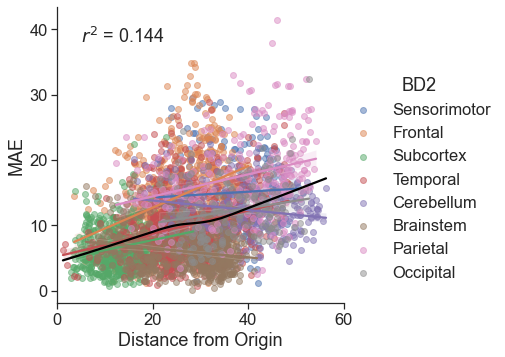

In [40]:
# plot relationship between distance/extremity and error, stratified by brain region

r2 = stats.pearsonr(preds_df.extremity,preds_df.total_error)[0]**2
sns.lmplot(x='extremity',y='total_error',data=preds_df,#lowess=True
          fit_reg=True,hue='BD2',scatter_kws={'alpha':0.5})
sns.regplot(x='extremity',y='total_error',data=preds_df,
          color='black',marker='',lowess=True)
plt.xlabel('Extremity')
plt.ylabel('MAE')
plt.xlim(40,100)
plt.text(45,38,'$r^{2}$ = %s'%round(r2,3))
#plt.savefig(os.path.join(fig_dir,'ErrVExtremity.pdf'),bbox_inches='tight')
plt.show()

r2 = stats.pearsonr(preds_df.center_dist,preds_df.total_error)[0]**2
sns.lmplot(x='center_dist',y='total_error',data=preds_df, 
          fit_reg=True,hue='BD2',scatter_kws={'alpha':0.5})
sns.regplot(x='center_dist',y='total_error',data=preds_df,
         lowess=True,color='black',marker='')
plt.xlabel('Distance from Origin')
plt.ylabel('MAE')
plt.xlim(0,60)
plt.text(5,38,'$r^{2}$ = %s'%round(r2,3))
#plt.savefig(os.path.join(fig_dir,'ErrVCenterDist.pdf'),bbox_inches='tight')
plt.show()


# 3D Plots

In [41]:
def generate_3d_plot(embedding,values,size=5,outfile='test.html',palette=plt.cm.tab10):
    '''
    embedding = a Nx3 2d np.array representing x,y,z coordinates of all N samples
    values = an array of categorical values to use to color each point
    size = size of points on plot (int)
    outfile = path, filename and extension of desired output file
    '''
    code = dict(zip(list(set(values)),range(len(list(set(values))))))
    labs = [code[x] if pandas.notnull(x) else 999 for x in np.array(values)]
    lmap = {v: k for k, v in code.items()}
    lmap.update({999: 'NaN'})
    traces = list()
    for lab in np.unique(labs):
        l_index = [x for x in range(len(labs)) if labs[x] == lab]
        l_embed = embedding[l_index]
        color_str = 'rgba %s'%str(tuple([x - 0.0000001 for x in palette(lab) if x > 0]))
        temp_trace = plotly.graph_objs.Scatter3d(x=l_embed[:,0],
                                                y = l_embed[:,1],
                                                z = l_embed[:,2],
                                                name = lmap[lab],
                                                mode = 'markers',
                                                marker = dict(size=size,
                                                              color=color_str
                                                             )
                                                )
        traces.append(temp_trace)

        layout = plotly.graph_objs.Layout(margin = dict(l=0,r=0,b=0,t=0))

    fig = plotly.graph_objs.Figure(data=traces, layout=layout)
    plotly.offline.plot(fig, 
                        filename=outfile)

In [42]:
# true coordinates, colored by dev brain segments
generate_3d_plot(embedding=gdf[['abs_mni_nlin_x','mni_nlin_y','mni_nlin_z']].values,
                 values=g2.Neural_Tube_segment.values,
                 outfile='NT_brain_test.html')

In [43]:
# predicted coordinates, colored by dev brain segments
generate_3d_plot(embedding=preds_df[['predicted_x','predicted_y','predicted_z']].values,
                 values=g2.Neural_Tube_segment.values,
                 outfile='GCorr_NT_brain_predicted_test.html')

In [44]:
# true coordinates, colored by brain divisions
generate_3d_plot(embedding=gdf[['abs_mni_nlin_x','mni_nlin_y','mni_nlin_z']].values,
                 values=g2.brain_divison.values,
                 palette=plt.cm.tab20,
                 outfile='brain_test.html')

In [45]:
# predicted coordinates, colored by brain divisions
generate_3d_plot(embedding=preds_df[['predicted_x','predicted_y','predicted_z']].values,
                 values=g2.brain_divison.values,
                 palette=plt.cm.tab20,
                 outfile='brain_predicted_test.html')

# Rotation sensitivity analysis
This analysis is to ensure the gene expression results are not spatially dependent on the intrinsic orientation of the brain

In [47]:
from scipy.spatial.transform import Rotation as R

# number of rotations
n_rots = 100

# get rotations
rot = R.random(n_rots,random_state=123
              ).as_euler('yzx', degrees=True)
tfm = R.from_euler('yzx',rot)

# create empty matrics to receive rotated coordinates
#new_coords = np.zeros((len(tr_y.index),3,n_rots)) # training set
new_coords = np.zeros((len(full_y.index),3,n_rots)) # full dataset

# for each coordinate
for i,idx in enumerate(full_y.index):#tr_y.index):
    coord = gdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x',]].loc[idx] # get coordinate
    rotated = tfm.apply(coord) # apply all random rotations to coordinate
    new_coords[i,:,:] = rotated.T # stor rotated coordinates

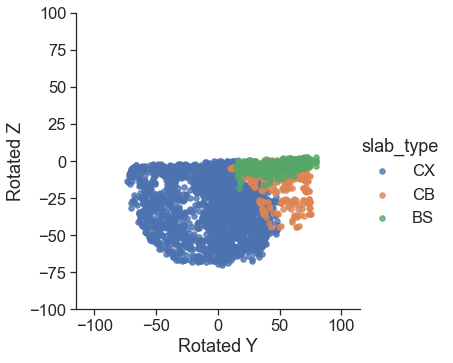

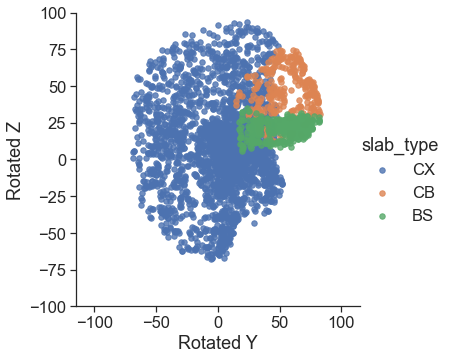

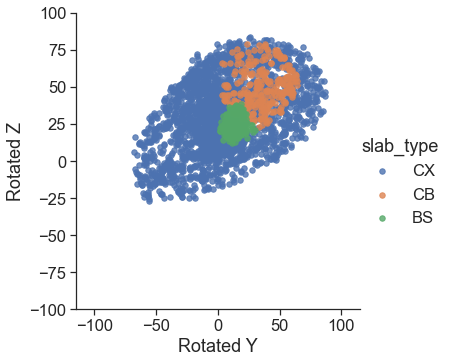

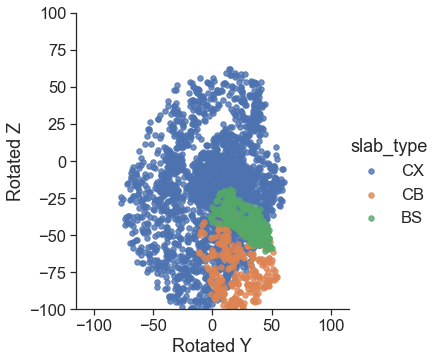

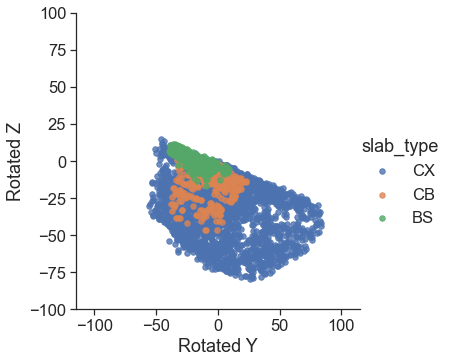

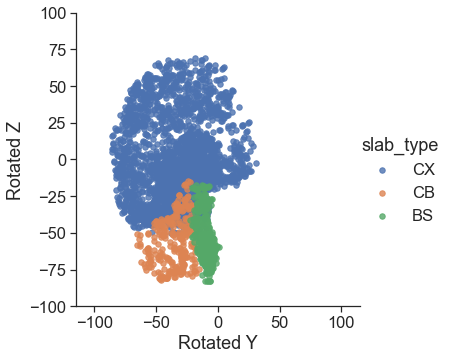

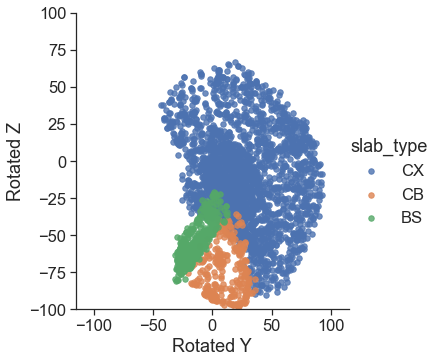

In [49]:
# Let's have a look at some example rotations

# example spins
for i,t in enumerate([4,22,37,49,63,84,90]):
    test = pandas.DataFrame(new_coords[:,:,t],columns=['y','z','x'])
    test.loc[:,'slab_type'] = gdf.loc[full_y.index,'slab_type'].values

    sns.lmplot(x='y', y='z', hue = 'slab_type', data=test, 
               fit_reg=False, scatter_kws={"s": 30})
    plt.xlabel('Rotated Y')
    plt.ylabel('Rotated Z')
    plt.ylim(-100,100)
    plt.xlim(-115,115)
#     plt.savefig(os.path.join(fig_dir,'random_rotation_%s.png'%i),
#                bbox_inches='tight')
    plt.show()

For each rotation, we're going to 

1) run PLS the same 3-component PLS as we did above, but substituting in the rotated coordinates instead of the empirical coordinates

2) Figure out which components are matched the empirical components by comparing their loadings

3) Store the rotated x loadings

In [53]:
# make some dataframes to store information
loadingsX = pandas.DataFrame(pls_mod.x_loadings_,
                         columns = ['orig_C1','orig_C2','orig_C3'])
compmapX = pandas.DataFrame(index=range(n_rots),
                          columns = ['C1','C2','C3',
                                     'C1_r2','C2_r2','C3_r2']) 

for i in range(n_rots): # for each rotation
    if i%10==0: print('Working on rotation',i) # keep progress
    
    # fit model
    rmod = PLSRegression(n_components=3,)
    #rmod.fit(tr,new_coords[:,:,i]) # for training set
    rmod.fit(pca_tfm,new_coords[:,:,i]) # for full data
    
    # compare rotated and empirical x loadings
    comp = np.concatenate([pls_mod.x_loadings_,rmod.x_loadings_],1)
    comp = (np.corrcoef(comp.T)**2)[:3,3:]
    
    # match rotated LVs to empirical LVs
    matched = []
    for k,v in dict(zip(['C1','C2','C3'],[0,1,2])).items():
        # find most similar empirical component
        vec = comp[v].tolist()[:]
        match = np.argmax(vec)
        # if that component was already "taken", use next most similar
        if match in matched:
            vec[match] = 0
            match = np.argmax(vec)
            # same thing here
            if match in matched:
                vec[match] = 0
                match = np.argmax(vec)
        matched.append(match)
        # record closest match and the R2 of that association
        compmapX.loc[i,k] = match
        compmapX.loc[i,'%s_r2'%k] = comp[v,match]
    #compmapX.to_csv('data/GCORR_Rotation_matches_fullX.csv')
    
    # just in case, store loadings store
    loadingsX.loc[:,'r%s_C1'%i] = rmod.x_loadings_[:,0]
    loadingsX.loc[:,'r%s_C2'%i] = rmod.x_loadings_[:,1]
    loadingsX.loc[:,'r%s_C3'%i] = rmod.x_loadings_[:,2]
    #loadingsX.to_csv('data/GCORR_loadings_fullX.csv')
    

Working on rotation 0
Working on rotation 10
Working on rotation 20
Working on rotation 30
Working on rotation 40
Working on rotation 50
Working on rotation 60
Working on rotation 70
Working on rotation 80
Working on rotation 90


Now let's visualize similarity of LVs across rotations, but ordering the data by LV. We should see a nice three block pattern if the data is robust to spatial rotations, because the rotations should not really be changing the x loadings. 

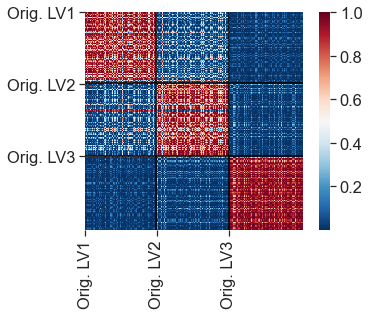

In [55]:
jnk = pandas.DataFrame((np.corrcoef(loadingsX.T)**2),
                      index=loadingsX.columns,
                      columns=loadingsX.columns)
sorder = [x for x in jnk.index if 'C1' in x] + [x for x in jnk.index if 'C2' in x] +\
         [x for x in jnk.index if 'C3' in x]
g = sns.heatmap(jnk.loc[sorder,sorder],cmap='RdBu_r',square=True)
g.set_xticks([0,100,200])
g.set_xticklabels(['Orig. LV1','Orig. LV2','Orig. LV3'])
g.set_yticks([0,100,200])
g.set_yticklabels(['Orig. LV1','Orig. LV2','Orig. LV3'])
g.hlines([99, 200], *g.get_xlim(),colors='black')
g.vlines([99, 200], *g.get_xlim(),colors='black')
#plt.savefig(os.path.join(fig_dir,'Rotated_PLS_Heatmap.png'),bbox_inches='tight')

Great! Looks very solid indeed! Now let's just summarizing how similar the rotated PLS X loadings are to the empirical PLS X loadings

Text(0, 0.5, 'Comparison to \nOrig. LV (R$^2$)')

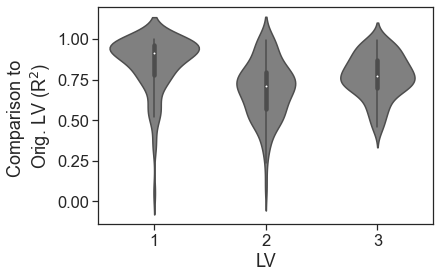

In [56]:
compr = pandas.DataFrame(pandas.concat(
              [pandas.Series(jnk.loc['orig_C1',[x for x in jnk.columns if 'C1' in x][1:]]),
               pandas.Series(jnk.loc['orig_C2',[x for x in jnk.columns if 'C2' in x][1:]]),
               pandas.Series(jnk.loc['orig_C3',[x for x in jnk.columns if 'C3' in x][1:]]),],
                         ))
compr.columns = ['R2']
compr.loc[:,'LV'] = [1]*100 + [2]*100 + [3]*100

sns.violinplot(x='LV',y='R2',data=compr,color='gray',)
plt.ylabel('Comparison to \nOrig. LV (R$^2$)')
#plt.savefig(os.path.join(fig_dir,'RotationPLS_Comps.pdf'),bbox_inches='tight')

# Save progress

In [46]:
gdf.to_csv('data/PLS_GXp_gdf.csv')